# Week 3: CHD Classification

## Introduction

Hey! Here's the decision trees assignment for this week! We're going to be using decision trees, and bootstrapped and boosted decision trees to classify whether patients are likely to develop coronary heart disease. Our dataset is taken from patients from the town of Framington Massachusetts.

Throughout the document, the elements labeled with TODO are the ones you have to fill-in.

## Python Libraries
As always, first we import our tools. Don't worry if some of these packages seem weird to you right now; we'll explain everything when we use them.

In [ ]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
import math

## Dataset
Now we load the dataset, clean up the data, and split it into a train and a test subsets so we can measure the accuracy of our model. We also perform some data cleaning in the middle, which you're going to help with! Look at the comment labeled TODO, and put your code right under it.

In [ ]:
data = pd.read_csv('framingham.csv')

#Some of the columns have NA elements, so we have to replace all of these elements
#For some of the columns, we want to replace the NA elements with 0 (the categorical variables), 
#and others we want to use the mean

columns_with_invalid_zeros_mean = ['glucose', 'cigsPerDay', 'totChol', 'BMI','heartRate']
columns_to_put_zero = ['education','BPMeds']
for col in columns_with_invalid_zeros_mean:
    mean = data[col].mean()
    data[col].fillna( mean, inplace=True)
for col in columns_to_put_zero:
    data[col].fillna(0, inplace=True)


#TODO: Rename the last column, currently called "TenYearCHD" to "target" for convenience. 
#Hint: Use Dataframe methods.
data.rename(columns={ "TenYearCHD": "target" }, inplace=True)


# Note: we set `random_state` to ensure the same result every time we run the code
data_train, data_test = train_test_split(data, train_size=.9, random_state=42)

It is always a good idea to look at the raw data and check that everything looks alright.

In [ ]:
data.head() #Shows the first 5 rows of the data

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,target
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


## Verifying Class Balance
Since we split the database into two randomly, the balance of classes (number of healthy vs diseased outcomes) might be different between the training data and the test data. This would likely cause the model to perform very poorly because it would think healthy outcomes are either less or more common than they really are.

This is a also a good time to check that our original data had balanced classes to begin with. If it did not, the model might learn to, for example, never classify a patient as having CHD since CHD is rare. It is like assuming about every person you meet that they cannot possibly have a billion dollars since almost nobody does. You would be right in 99% of cases, but if you met Jeff Bezos you would also never guess he is a billionaire,

This is especially a problem with decision trees, since at some point, the model just assigns the most probable class as the output (when it gets to a leaf), so class imbalance could seriously hinder our training. 


Finally, this makes sense as a benchmark for model performance. A very naive model could just roll a die and respond randomly, with the chance of diabetes being its prevalence in the general population. It would be right more often than guessing 50-50, but would still fail to use any of the biometric data.
We've filled in the calculation of the proportion of healthy people for the entire dataset; **your job** is to fill it in for the training and testing dataset.

In [ ]:
healthy_proportion = len(data[data['target'] == 0]) / len(data)
healthy_proportion_train = len(data_train[data_train['target'] == 0]) / len(data_train) #TODO: Find proportion of healthy people in training data
healthy_proportion_test = len(data_test[data_test['target'] == 0]) / len(data_test) #TODO: Find proportion of healthy people in testing data
print(f'Dataset diabetes prevalence: {(1 - healthy_proportion) * 100:.2f}%')
print(f'Training data diabetes prevalence: {(1 - healthy_proportion_train) * 100:.2f}%')
print(f'Test data diabetes prevalence: {(1 - healthy_proportion_test) * 100:.2f}%')
print('All three values should be similar.')
print('None of the values should be outrageously low <10%.')

Dataset diabetes prevalence: 15.20%
Training data diabetes prevalence: 15.23%
Test data diabetes prevalence: 14.86%
All three values should be similar.
None of the values should be outrageously low <10%.


## Features and Labels
Now we extract the features (the biometrics) and the labels (the outcome) from the data.

This step is required since the dataset does not tell the model which parameter it should be predicting.

In [ ]:
y = data_train['target']
X = data_train.drop('target', axis=1)

In [ ]:
y_test = data_test['target']
X_test = data_test.drop('target', axis=1)

## Decision  Trees
We define a function for creating a decision tree with a given maximum depth. Later we compare trees of different depth and how their accuracy changes. 

**TODO**: In this method, make sure to fill in arguments to the DecisionTreeClassifier constructor so that max_depth and criterion are accounted for. **Additionally**, we want to only split a node if it has 50 samples or more (figure out what argument to pass into the constructor for this [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html))

In [ ]:
def decision_tree(X,y,max_depth=2, criterion="gini", sample_weight=None):
    tree = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, min_samples_split=50) #TODO: Fill in arguments to this constructor
    tree.fit(X, y, sample_weight=sample_weight)
    return tree

## A Few Utilities
These functions can display a tree as a graphic, and print its accuracy on both the training and the test data. Fill in the class labels, that'll be used to label the leaves of the tree.

In [ ]:
def show_tree(tree):
    feature_names = data.columns
    #TODO: Assign class_names to a list [x,y], where 
    #x is the name of the class assigned to 0
    #y is the name of the class assigned to 1
    class_names = ['healthy outcomes', 'diseased outcomes']

    fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(4, 2), dpi=300)
    plot_tree(tree,
              feature_names=feature_names, 
              class_names=class_names,
              ax=axis,
              filled=True,
              impurity=False);

This function helps us print the accuracy of a tree. We'll use it when testing.

In [ ]:
def print_accuracy(tree):
    train_acc = tree.score(X, y) * 100
    test_acc = tree.score(X_test, y_test) * 100
    
    print(f'Train accuracy: {train_acc:.1f}%')
    print(f'Test accuracy: {test_acc:.1f}%')
    return train_acc, test_acc

We'll also need a function to plot the accuracies of the trees for different depths. Enter, `plot_accuracies`

In [ ]:
def plot_accuracies(accuracies):
    train_accuracy_plot = plt.plot([x[0] for x in accuracies], label='Train accuracy')
    test_accuracy_plot = plt.plot([x[1] for x in accuracies], label='Test accuracy')
    plt.legend()


Finally, some machine learning! Here, we're going to train the tree on the dataset, limiting the tree to different depths and checking how accuracy changes

In [ ]:
accuracies = []
trees=[]
for i in range(1, 15):
    tree = decision_tree(X, y, i) #TODO: Fill in the arguments to decision_tree
    trees.append(tree)
    print(f'Max depth: {i}')
    accuracies.append(print_accuracy(tree))

Max depth: 1
Train accuracy: 84.8%
Test accuracy: 85.1%
Max depth: 2
Train accuracy: 84.8%
Test accuracy: 85.1%
Max depth: 3
Train accuracy: 85.0%
Test accuracy: 84.9%
Max depth: 4
Train accuracy: 85.3%
Test accuracy: 83.5%
Max depth: 5
Train accuracy: 85.8%
Test accuracy: 83.3%
Max depth: 6
Train accuracy: 86.1%
Test accuracy: 82.5%
Max depth: 7
Train accuracy: 86.3%
Test accuracy: 81.8%
Max depth: 8
Train accuracy: 86.4%
Test accuracy: 81.8%
Max depth: 9
Train accuracy: 86.5%
Test accuracy: 81.1%
Max depth: 10
Train accuracy: 86.5%
Test accuracy: 81.1%
Max depth: 11
Train accuracy: 86.6%
Test accuracy: 81.1%
Max depth: 12
Train accuracy: 86.8%
Test accuracy: 81.1%
Max depth: 13
Train accuracy: 86.8%
Test accuracy: 80.9%
Max depth: 14
Train accuracy: 86.9%
Test accuracy: 80.9%


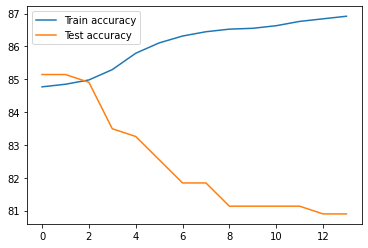

In [ ]:
plot_accuracies(accuracies)

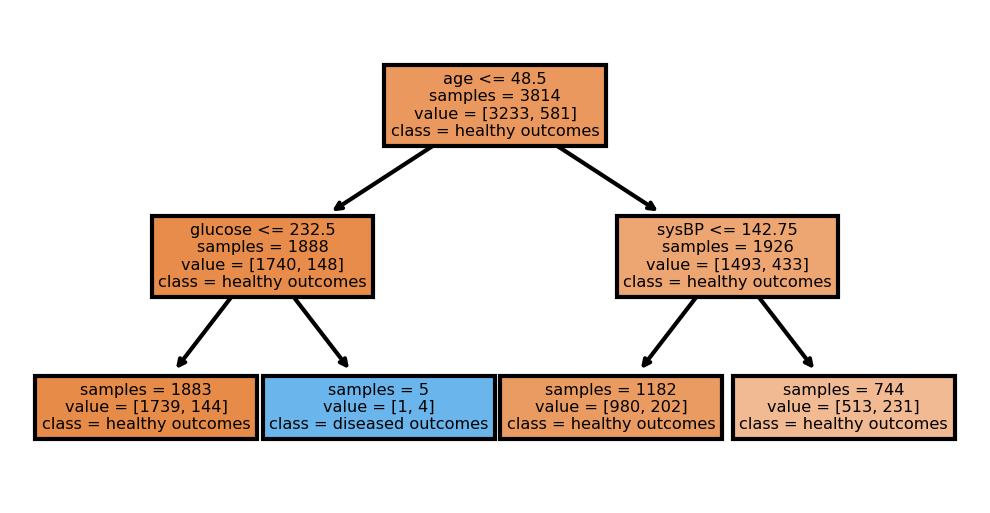

In [ ]:
show_tree(trees[1])#Change the index to see trees with different depth. Notice anything particular about trees[0]?

So what happened! Well, as the above graph shows, as we kept increasing the tree depth, our training accuracy went up, but our testing accuracy stayed the same. What is the standard name for this phenomenon, that we learned about in lecture?

The standard name for this phenomenon is overfitting


## Random Forests

We're going to mitigate this problem by using Random Forests, the collection of decision trees we learned about in lecture. In this case, to understand the internal workings of a random forest, we're going to implement it as a collection of decision trees (note that in real life you would usually just use sci-kit learn's Random Forest algorithm, but here we're reinventing the wheel)


### Method 1: Bootstrapping

The first method we have to make is the `bootstrap_sample` method, which draws a bootstrap sample as we described in lecture. You're going to get to implement this one!

Remember from lecture that a bootstrap sample of size n draws n elements from the dataset, **with replacement**. That means the same element can appear multiple times in the sample.

X and y are the data that we will be sampling from. 
$$X=
\begin{bmatrix} 
-2&54&0&\dots &2\\
0&0&3&\dots &0\\
\dots \\
657&32&-6&8&\dots&1
\end{bmatrix}$$
$$y=\begin{bmatrix}
1\\0\\\dots\\1
\end{bmatrix}
$$
X has as many rows as there are examples in the dataset, and as many columns as there are features for each example.
Y also has as many rows as there are examples.
In fact, row $i$ in $X$ is the features for example $i$, and row $i$ in y is the output for example $i$.

In [ ]:
#TODO: Implement bootstrap_sample.
#Parameters:
#X- All training data, as a Pandas Dataframe
#Y - All the expected outputs as a Pandas Series
#n - How many examples we want to be in the sample
#Returns:
#The features and correct outputs for the random_sample
#(should follow the same format as X and y, just with only examples selected for the sample).
def bootstrap_sample(X,y,n):
    #TODO: YOUR CODE HERE
    X_sample = X.sample(n=n, replace=True)
    y_sample = y[X_sample.index]
    return X_sample,y_sample

Now we're going to have to implement feature_sample. When random forests were first created, they would only do the above step of using bootstrapped samples for each tree. However, people who used them found that they were still very likely to over fit on the data. To prevent this overfitting, we add a second layer of randomness; each tree in the forest only gets to train on some random subset of the features. Here, we implement the process of choosing this random subset.

Note that the function should return both the dataset with only `num_features` features, as well as the indices of exactly which columns they kept, in a list. For example, if:
$$X=\begin{bmatrix}1&0&0&1\\0&1&0&1\end{bmatrix}$$
and `num_features=2`, then one possible return value could be:
$$X_{features}=\begin{bmatrix}1&0\\0&1\end{bmatrix}, cols=[0,1]$$

In [ ]:
#TODO: Implement feature_sample
#Parameters:
#X- Training data, as a Pandas Dataframe
#num_features - the number of features of the dataframe to keep
#Returns:
#The dataset, with only num_features features, as well as the indices of which columns were kept. 
def feature_sample(X,num_features):
    #TODO: YOUR CODE HERE
    X_features = X.sample(n=num_features, axis=1)
    cols = []
    for i in X_features.columns:
      cols.append(X.columns.get_loc(i))
    return X_features,cols

Finally, we get to the actual bootstrapped random forest! See each line for instructions on what to do. Also, there are some values here which you get to choose; feel free to play around with them to see what gives you the best accuracy. If you want to see what I used, I'll put the values up on Piazza next week. Note that if you run the later cells in this notebook, and come back here to change something, make sure to run this cell again.

In [ ]:
def bootstrap_random_forest(num_trees=20,depth=2):
    trees=[]
    for _ in range(num_trees):
        x_tree,y_tree=bootstrap_sample(X, y, 2860) #TODO: Fill in the arguments to this call
        x_tree,cols=feature_sample(x_tree, 4) #TODO: Fill in the second argument to this call
        dt=decision_tree(x_tree,y_tree,max_depth=depth) 
        trees.append((dt,cols))
    return trees

Now, we have to use a function that can apply our model to the test set. Remember that in a bootstrapped random forest, we take a majority vote of all the trees to see what prediction to give on each example.

In [ ]:
def score_bootstrap_random_forest(rf, X,y):
    individual_tree_predictions = [x.predict(X.iloc[:,cols]) for x,cols in rf]
    #TODO: YOUR CODE HERE
    #HINT: preds should be an array of 0s and 1s at the end, and individual_predictions 
    #contains the predictions of each tree on the entire test set.
    preds=[]
    for i in range(len(y)):
      vote = 0
      for tree in individual_tree_predictions:
        vote += tree[i]
      if vote > len(individual_tree_predictions)/2:
        preds.append(1)
      else:
        preds.append(0)
    return accuracy_score(y,preds)
accuracies=[]

Now, we just run our bootstrap_random_forests for a bunch of different depths to produce accuracies. Note that if you change any of the above cells, you only have to run the cell you changed and this cell, not all of the definitions.

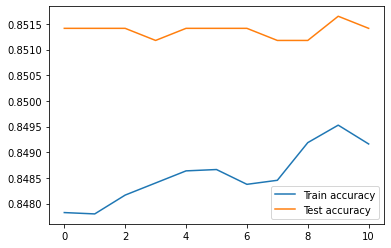

In [ ]:
for x in range(2,13):
    accum=[0,0]
    for i in range(10):
        rf = bootstrap_random_forest(20,depth=x)
        accum[0]+=score_bootstrap_random_forest(rf,X,y)
        accum[1]+=score_bootstrap_random_forest(rf,X_test,y_test)
    accuracies.append((accum[0]/10,accum[1]/10))
plot_accuracies(accuracies)            

## Method 2: Boosting

Now, bootstrapping is well and good, but three's something unsatisfying about it. We're just going to assign each tree a random subset of a data, a random subset of features, and hope everything works out? In particular, what stops all the trees from learning the same thing, and thus making the "forest" useless? Well, never fear, for boosting is here.

The basic idea of boosting, as we discussed in lecture, is that each tree empahsizes the other tree's errors, so we know that together, all the trees cover the entire dataset. The AdaBoost framework is the most popular way of implementing this idea, so it's what we're going to be implementing today. Ada boost is an algorithm of iterations, that can run many times. Each iteration has the following steps:
- We figure out the best tree for the data, with the data's current weights (how important each example is). Either this tree is already in our forest, or we have to train a new tree, and add it in our forest. The way that we specifically do this is by calculating, for each tree, the sum of the weights of all examples it gets wrong. The tree that has the smallest such quantity is the one we choose, and we call that quantity $\epsilon$
- We calculate what the weight of this "best" tree should be, and we set its weight to that. The new weight (which we call $\alpha$) of the  tree is, 
$$\alpha=\frac{1}{2}\ln\left(\frac{1-\epsilon}{\epsilon}\right)$$
- We then have to update the weights of each of the examples. For an example i, let h be the best tree, which returns 1 for positive classifications, and -1 for negative classifications, and let y(x) be the actual result for example x, either 1 or -1 again (if this sounds confusing don't worry, it'll be explained more clearly when we get there). The formula for the updates is then
$$w_{new}(i)=\frac{w_{old}(i)}{C_{\text{normalization}}}e^{-\alpha*h(i)*y(i)}$$


Note that $C_{\text{normalization}} is just there to make sure the weights still sum to 1. We iterate over these 3 steps for a set number of iterations, and then we apply it to the testing set.

### Step 1: Finding (or creating) the best_tree

In order to grade each tree and decide which is the best, we have to compute the hypothetical $\epsilon$ value for each tree, and then choose the tree that produces the minimum one. We first have to create a tree and fit it to the data, and get its $\epsilon$ value. Then we see if there is any existing tree that beats it. If not, then we add the new tree to our forest, and if so, then we just use the existing tree. 

In [ ]:
#Parameters:
#trees- a list of all the trees, over which we are searching for the best one
#weights - the weights for each of the examples in the training data
#X - the training data
#y - the testing deta
#depth - the depth of the tree that we should create and add to our trees, if none of the other trees are better.
#Returns:
#Either a tuple (bestIndex, best_epsilon), where bestIndex is the index of the tree that performed the best, and best_epsilon is its epsilon value
#or, (best_epsilon,) which is when we've added a new tree to the end of the trees list, and we're sending its epsilon value
def best_tree(trees,weights,X,y,depth):
    new_tree=decision_tree(X, y, max_depth=depth, sample_weight=weights) #TODO: Fill in arguments to get tree trained on X and y, with weights w.
    threshold=sum([weights[i] for i in np.where(new_tree.predict(X)!=y)[0]]) #TODO: Calculate the epsilon value for new_tree. 
    best_epsilon=len(X)
    bestIndex=None
    for i,tree in enumerate(trees):
        tree_epsilon = sum([weights[i] for i in np.where(tree.predict(X)!=y)[0]])#TODO: Fill in this to calculate epsilon for a given tree.
        if tree_epsilon<best_epsilon:
            #TODO: Fill out to properly update best_epsilon and bestIndex
            best_epsilon = tree_epsilon
            bestIndex = i
    if best_epsilon>threshold:
        trees.append(new_tree)
        return (threshold,) #This return signifies that the best tree was the new one, 
                            #so we are only sending the epsilon value, and not two arguments.
    return bestIndex, best_epsilon

### Step 2: Calculating $\alpha$

Now, we have to make a method to calculate $\alpha$, the coefficeint for a given tree, when we are given $\epsilon$. Refer to the start of this section for the formula.

In [ ]:
#Parameters:
#tree_epsilon - the epsilon for the best tree that was found
#Returns:
#Calculated alpha value
def calculate_tree_alpha(tree_epsilon):
    if tree_epsilon>=1:
        return -1e6 #This is for numerical stability
    #TODO: Use the formula to calculate alpha, given epsilon.
    alpha = (1/2)*np.log((1-tree_epsilon)/tree_epsilon)
    return alpha

### Step 3: Updating the weights

Now, we have to update the weights for each of the examples. Here, we have a slight disconnect between the literature and what we have doing. In our y (outputs), we write 1 if there is CHD, and 0 if there's not. Most ML formula assume we will be using 1 and -1 as our outputs if we're doing two-way classification. The same applies to the outputs of decision trees; the formula assumes the tree outputs 1 and -1, not 1 and 0 like ours does, for its predictions. You will have to deal with this change when you are applying the formula.

Also, don't actually try to figure out the value of $C_{normalization}$ beforehand. Instead, compute the weights without it, and then just divide all of the weights by their sum. 

In [ ]:
#Parameters:
#weights - The original weights of each example
#best_tree - The tree that had the best epsilon values, given the example weights in weights
#y - The true output for each example
#alpha - The calculated alpha value for the best_tree
#Returns:
#The updated weights
def updateWeights(weights, best_tree,y,alpha):
    #TODO: YOUR CODE HERE
    predict = best_tree.predict(X)
    for i in range(len(X)):
      if predict[i]==0:
        weights[i]=weights[i]*np.e**(-alpha*-1*y.iloc[i])
      else:
        weights[i]=weights[i]*np.e**(-alpha*1*y.iloc[i])
    weights=weights/sum(weights)
    return weights

Finally, we need to make the actual boosted_random_forest method. There's a few to-dos here, so I'm not going to explain them here, suffice to say that you will need to call the methods you developed before at some points.

In [ ]:
def boosted_random_forest(X,y,num_iterations=90,depth=10):
    trees=[]
    tree_alphas=[]
    #TODO: Set weights to a numpy array that has the same number of rows as X (one row for each example), 
    #and the same element in each spot, but all the elements should add up to 1. 
    #Hint: https://numpy.org/devdocs/reference/generated/numpy.full.html 
    weights = np.full(len(X), 1/len(X))
    for i in range(num_iterations):
        print("Depth {}: Iteration {}".format(depth,i),end='\r')
        
        #TODO: We need the best tree of all the trees in the current list of trees; 
        #do we have a method to do that?
        result=best_tree(trees, weights, X, y, depth)
        if  len(result)==1:
            epsilon=result[0]
            tree_alphas.append(calculate_tree_alpha(epsilon))#TODO: Fix this line so it calculates alpha, and adds it to tree_alphas
            #TODO: Fix this line so that it updates the weights correctly
            #(hint: how can we access the tree that was just created?)
            weights = updateWeights(weights, trees[-1], y, tree_alphas[-1])
        else:
            epsilon=result[1]
            tree_alphas[result[0]]=calculate_tree_alpha(epsilon) #TODO: Fix this line so it calculates alpha, and sets it in tree_alphas
            chosen_tree=trees[result[0]]
            #TODO: Fix this line so that it updates the weights correctly
            weights = updateWeights(weights, chosen_tree, y, tree_alphas[result[0]])
    return trees,tree_alphas

Now, we just write the scoring function for AdaBoost. 

In [ ]:
def score_boosted_random_forest(rf,X,y):
    lis=[(rf[0][i].predict(X)*2-1)*rf[1][i] for i in range(len(rf[0]))]
    total=reduce(np.add, lis)
    preds=(np.sign(total)+1)/2
    return accuracy_score(preds,y)

Now, we finally score the model for a bunch of different depths.

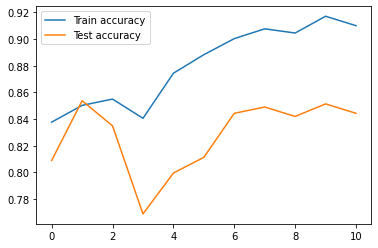

In [ ]:
accuracies=[]
for x in range(2,13):
    rf = boosted_random_forest(X,y,depth=x)
    accuracies.append((score_boosted_random_forest(rf,X,y),score_boosted_random_forest(rf,X_test,y_test)))
plot_accuracies(accuracies)

You might notice that the test accuracy of the random forest is actuallly  better than either AdaBoost or decision trees(hint; if your random forest isn't doing too well, try raising the amount of data in each bootstrap sample, or the amount of fatures that each tree gets to use). In your own words, explain why AdaBoost has bad test accuracy, even as such an advanced algorithm.

AdaBoost trains the tree on previous errors which means that it would not know whether or not the previous tree got its prediction correct and it would lead the further trees to make mistakes in training.

Something to ponder; Even though 86% accuracy might seem pretty good, why is that actually pretty terrible on this dataset? (Hint; take another look at the data cleaning section). This tells us that decision trees are probably not the best model for this data, unfortunately.

## References

[Dataset](https://www.kaggle.com/dileep070/heart-disease-prediction-using-logistic-regression)